In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')



In [2]:
import sklearn.tree as sktree
import sklearn.ensemble as skensemble
import sklearn.datasets as datasets
import sklearn.svm as sksvm

from sklearn.linear_model import Perceptron, SGDClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.auto import tqdm
import itertools

In [7]:
sksvm.SVC._validate_targets??

Signature: sksvm.SVC._validate_targets(self, y)
Docstring:
Validation of y and class_weight.

Default implementation for SVR and one-class; overridden in BaseSVC.
Source:   
    def _validate_targets(self, y):
        y_ = column_or_1d(y, warn=True)
        check_classification_targets(y)
        cls, y = np.unique(y_, return_inverse=True)
        self.class_weight_ = compute_class_weight(self.class_weight, classes=cls, y=y_)
        if len(cls) < 2:
            raise ValueError(
                "The number of classes has to be greater than one; got %d class"
                % len(cls)
            )

        self.classes_ = cls

        return np.asarray(y, dtype=np.float64, order="C")
File:      ~/.local/lib/python3.8/site-packages/sklearn/svm/_base.py
Type:      function


In [3]:
def ISLR2data(name):
    import io
    import zipfile
    import urllib
    url = ("https://www.statlearning.com/s/"
           "ALL-CSV-FILES-2nd-Edition-corrected.zip")
    zipdata = urllib.request.urlopen(url).read()
    with zipfile.ZipFile(io.BytesIO(zipdata)) as zf:
        for zi in zf.filelist:
            if name in zi.filename:
                with zf.open(zi) as f:
                    df = pd.read_csv(f, index_col=0)
                break
    return df

def ISLRdata(name):
    import statsmodels.datasets as smd
    data = smd.get_rdataset(name, 'ISLR')
    for k in ['__doc__', 'title', 'package']:
        setattr(data.data, k, getattr(data, k, ''))
    return data.data

def print_report(model, X, y):
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y, labels=model.classes_), 
                      columns=model.classes_, index=model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm

def viz2pdf(viz, fn):
    from reportlab.graphics import renderPDF
    from svglib.svglib import svg2rlg
    import io

    renderPDF.drawToFile(svg2rlg(io.BytesIO(viz.svg().encode())), 
                         fn, 
                         showBoundary=False)
    

In [4]:

#def svm_coef(svm):
#    return np.dot(svm.support_vectors_.T, svm.dual_coef_.squeeze())

def margin_lines(perceptron_or_svm,x=[0,1]):
    a,b = perceptron_or_svm.coef_.squeeze()
    x = np.asarray(x)
    return x,-(1+x*a+perceptron_or_svm.intercept_)/b, -(-1+x*a+perceptron_or_svm.intercept_)/b

def decision_line(perceptron_or_svm,x=[0,1]):
    a,b = perceptron_or_svm.coef_.squeeze()
    x = np.asarray(x)
    return x,-(x*a+perceptron_or_svm.intercept_)/b


0.005536665667389322
0.09380873068539795
0.03305170760982999


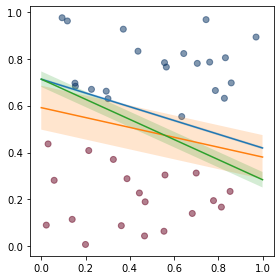

In [5]:
# some separable data point
rng = np.random.default_rng(42)
X = rng.uniform(size=(50, 2))
beta = np.array([.2, 1])
value = np.dot(X, beta)
value -= np.median(value)
idx = np.abs(value)>0.1
X = X[idx]
y = 2*(value[idx]>0)-1


plt.figure(figsize=plt.figaspect(1),
           tight_layout=True)

plt.scatter(x=X.T[0], y=X.T[1], c=y, cmap='RdBu', alpha=0.5)


ps=[Perceptron(random_state=16*i, shuffle=True).fit(X,y) for i in range(3)]

for p0 in ps:
    xs,ys = decision_line(p0)
    # plt.plot(xs, ys)
    margin = min(y*p0.decision_function(X))/(p0.coef_**2).sum()**0.5
    print(margin)
    plt.fill_between(xs,ys+margin,ys-margin,alpha=0.2)
for p0 in ps:
    xs,ys = decision_line(p0)
    plt.plot(xs, ys)

    
#plt.savefig('plots/12-10-perceptron.pdf')
plt.show()

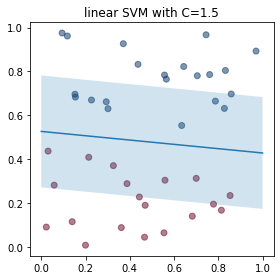

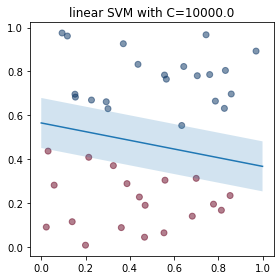

In [6]:

svms=[sksvm.SVC(C=c, 
                tol=1e-3,
                kernel='linear',
                shrinking=False,
                max_iter=10000).fit(X, 0.5*(y+1)) for c in [1.5, 10000]]

for i,svm in enumerate(svms):
    plt.figure(figsize=plt.figaspect(1),
               tight_layout=True)

    plt.scatter(x=X.T[0], y=X.T[1], c=y, cmap='RdBu', alpha=0.5)
    
    xs, ys0, ys1 = margin_lines(svm)
    plt.fill_between(xs, ys0, ys1, alpha=0.2)

    xs,ys = decision_line(svm)
    
    plt.plot(xs, ys)
    plt.title(f'linear SVM with C={svm.C:.1f}')
    
    # plt.savefig(f'plots/12-10-svm-sep{i+1}.pdf')
    plt.show()


In [10]:
def penalized_loss(X, y, beta, beta_0, C):
    f = np.dot(X, beta) + beta_0
    return C*(1-y*f).clip(0).sum()+0.5*(beta**2).sum()

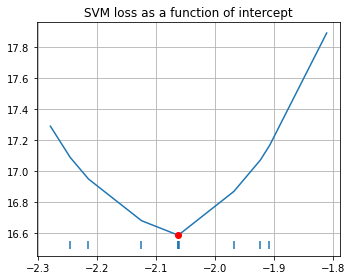

In [12]:
svm = svms[0]
# number of positive examples
k = (y+1).sum()//2

z0 = np.sort((y-np.dot(X, svm.coef_.squeeze())))

z = np.linspace(z0[k-5],z0[k+5],501)

g = [penalized_loss(X, y, svm.coef_.squeeze(), beta0, svm.C) for beta0 in z]

plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(z, g)
plt.grid()
plt.plot(svm.intercept_, penalized_loss(X ,y, svm.coef_.squeeze(), svm.intercept_, svm.C), 'or')

idx = (z0<max(z))*(z0>min(z))
z1 = z0[idx]
plt.scatter(z1, [min(g)-0.05*(max(g)-min(g))]*len(z1), marker='|', s=50)

plt.title('SVM loss as a function of intercept')
plt.show()
# plt.savefig('plots/12-10-svm-loss-intercept-fn.pdf')

In [13]:
def data_splits(X, y, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
    return {'train':(X_train, y_train),'test':(X_test, y_test)}


In [18]:
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron

X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

clf = Perceptron(tol=1e-5, 
                 random_state=1, 
                 # early_stopping=True,  #verbose=1, 
                 penalty='none')
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.965205288796103, 0.9638888888888889)

In [21]:
clf.intercept_, clf.coef_.min(), clf.coef_.max()

(array([ -6., -65.,  -5., -12.,   3., -14., -11.,  -4., -68., -21.]),
 -400.0,
 302.0)

(array([  4.,   9.,  19.,  42.,  99., 307., 110.,  37.,  10.,   3.]),
 array([-400. , -329.8, -259.6, -189.4, -119.2,  -49. ,   21.2,   91.4,
         161.6,  231.8,  302. ]),
 <BarContainer object of 10 artists>)

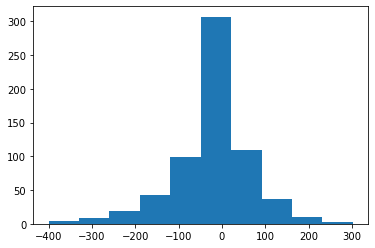

In [26]:
plt.hist(clf.coef_.ravel())

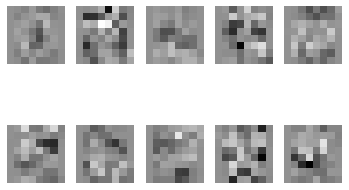

In [28]:
for i,c in enumerate(clf.coef_):
    plt.subplot(2,5,i+1)
    plt.imshow(c.reshape(8,8), cmap='gray', vmin=-400, vmax=302)
    plt.axis('off')
# plt.colorbar()
plt.show()

number of misclassified test examples: 13


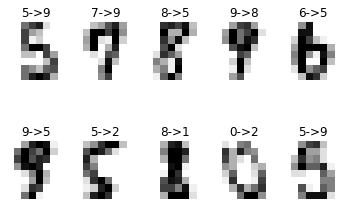

In [30]:
img_shape =(8, 8)
y_pred = clf.predict(X_test)
print(f'number of misclassified test examples: {(y_pred!=y_test).sum()}')
idx = (y_pred!=y_test).nonzero()[0]
idx = np.random.choice(idx,size=10, replace=False)
# y_pred = clf.predict(X_test[idx])
for i, (img, y0, y1) in enumerate(zip(X_test[idx], y_test[idx], y_pred[idx])):
    plt.subplot(2,5,i+1)
    plt.imshow(-img.reshape(*img_shape), cmap='gray')
    plt.axis('off')
    plt.title(f'{y0}->{y1}')
plt.show()

#plt.imshow(-X_test[0].reshape(8,8), cmap='gray')
#


In [31]:
pd.DataFrame(enumerate(*clf.decision_function(X_test[:1])), columns=['label','score'])

,label,score
0,0,-5251.0
1,1,-10261.0
2,2,-6305.0
3,3,-11955.0
4,4,-7202.0
5,5,-3555.0
6,6,4451.0
7,7,-7170.0
8,8,-6608.0
9,9,-3191.0


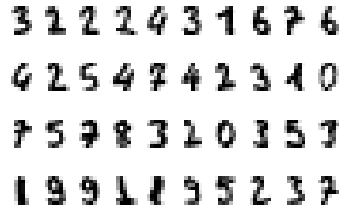

In [32]:
img_shape =(8, 8)
for i,idx in enumerate(np.random.choice(len(X),size=40, replace=False)):
    plt.subplot(4,10,i+1)
    plt.imshow(16-X[idx].reshape(8,8), cmap='gray')
    plt.axis('off')
plt.show()


In [30]:
1/(64*X_train.var())

0.0004304938200020348

In [33]:
# from sklearn.model_selection import GridSearchCV
digit_svm = sksvm.SVC(C=10, gamma=0.0004).fit(X_train,y_train)
digit_svm.score(X_train, y_train), digit_svm.score(X_test, y_test), len(digit_svm.support_), len(X_train)

(1.0, 0.9861111111111112, 568, 1437)

In [37]:
#default kernel is rbf!
digit_svm_cv = GridSearchCV(sksvm.SVC(), 
                            dict(C=[0.1,1,10, 100], 
                                 gamma=0.0004*np.logspace(-2,2,5)),
                            cv = 5,
                            refit = True,
                            ).fit(X_train,y_train)

In [35]:
np.logspace(-2,2,5)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [38]:
digit_svm_cv.score(X_test,y_test), digit_svm_cv.best_params_

(0.9861111111111112, {'C': 10, 'gamma': 0.0004})

In [39]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler

In [47]:
#LogisticRegressionCV?

In [44]:
digit_logreg = make_pipeline(MinMaxScaler(),
                             LogisticRegressionCV(Cs=[0.1, 0.5, 1, 2.5, 10], 
                                                  refit=True, 
                                                  multi_class='multinomial',
                                                  cv=5,
                                                  random_state=42, 
                                                  penalty='l2', 
                                                  scoring='accuracy',
                                                  verbose=1,
                                                  solver = 'newton-cg',
                                                  n_jobs=4)).fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


In [45]:
digit_logreg.score(X_train, y_train), digit_logreg.score(X_test, y_test), digit_logreg[-1].C_

(0.9916492693110647,
 0.9722222222222222,
 array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]))

In [46]:
digit_logreg[-1].coef_.shape

(10, 64)

In [48]:
#digit_adaboost?

In [51]:
digit_adaboost = skensemble.AdaBoostClassifier(#base_estimator=sktree.DecisionTreeClassifier(max_depth=4),
                                               base_estimator=skensemble.RandomForestClassifier(max_leaf_nodes=16,
                                                                                                n_estimators=20),
                                               learning_rate=0.05,
                                               n_estimators=500).fit(X_train, y_train)
digit_adaboost.score(X_train, y_train), digit_adaboost.score(X_test, y_test)

(1.0, 0.9833333333333333)

In [57]:
digit_gbm = skensemble.GradientBoostingClassifier(n_estimators=1000,
                                                  subsample=0.5, 
                                                  max_leaf_nodes=16, 
                                                  learning_rate=0.05, 
                                                  random_state=1,
                                                  verbose=1).fit(X_train, y_train)
make_scorer(accuracy_score)(digit_gbm, X_train, y_train), digit_gbm.score(X_test, y_test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.9672           0.2885            1.12m
         2           1.7655           0.1999            1.04m
         3           1.5883           0.1513            1.02m
         4           1.4570           0.1289           58.90s
         5           1.3480           0.0987           57.97s
         6           1.2468           0.0855           56.72s
         7           1.1800           0.0846           55.05s
         8           1.0884           0.0727           53.56s
         9           1.0184           0.0607           53.31s
        10           0.9438           0.0598           52.85s
        20           0.5173           0.0247           49.20s
        30           0.3140           0.0116           47.57s
        40           0.2112           0.0060           46.89s
        50           0.1328           0.0036           46.28s
        60           0.0954           0.0020           45.52s
       

(1.0, 0.9861111111111112)

In [58]:
import lightgbm

In [ ]:
digit_lgbm = lightgbm.LGBMClassifier(n_estimators=1000,  num_leaves=8, learning_rate=0.01, reg_alpha=0.001).fit(X_train, y_train)
digit_lgbm.score(X_train, y_train), digit_lgbm.score(X_test, y_test)

(1.0, 0.9805555555555555)

In [80]:
digit_lgbm = lightgbm.LGBMClassifier(n_estimators=100,  
                                     num_leaves=8, 
                                     learning_rate=0.2, 
                                     reg_alpha=0.001, 
                                     reg_lambda=0.001,
                                     #bagging_freq=1,
                                     #bagging_fraction=0.5,
                                     subsample=0.5
                                     #feature_
                                    ).fit(X_train, y_train)
digit_lgbm.score(X_train, y_train), digit_lgbm.score(X_test, y_test)

(1.0, 0.9805555555555555)

In [81]:
digit_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 8,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'silent': 'warn',
 'subsample': 0.5,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [83]:
import xgboost

In [84]:
digit_xgboost = xgboost.XGBClassifier(use_label_encoder=False, 
                                      n_estimators=75, 
                                      tree_method='hist',
                                      grow_policy='lossguide',
                                      max_leaves=8,
                                      max_depth=None, 
                                      reg_alpha=0.0001,
                                      reg_lambda=0.001,
                                      colsample_bynode=0.5,
                                      subsample=0.5,
                                      learning_rate=0.2).fit(X_train, y_train)
digit_xgboost.score(X_train, y_train), digit_xgboost.score(X_test, y_test)

[14:52:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(1.0, 0.9805555555555555)

In [85]:
digit_xgboost.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 0.5,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 75,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.001,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': None,
 'grow_policy': 'lossguide',
 'max_leaves': 8}

# MNIST

In [124]:
from sklearn.metrics import confusion_matrix
def make_cm(model, X, y):
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y), 
                      columns=model.classes_, index=model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm

In [125]:

use_openml=False
use_tfds=False

if use_openml:
    X, y = datasets.fetch_openml('mnist_784', return_X_y=True)
    print(X.shape, y.shape)
elif use_tfds:
    import tensorflow_datasets as tfds
    mnist = tfds.load('mnist')
    train = mnist['train']
    X,y = zip(*train.map(lambda x: (x['image'], x['label'])).as_numpy_iterator())
    X = np.stack(X)
    y = np.stack(y)
    print(type(X), type(y), X.shape, y.shape)

    np.savez_compressed('mnist_train.npz',X=X, y=y)
else:
    mnist_data =np.load('mnist_train.npz')
    X = mnist_data['X']
    y = mnist_data['y']

1/X.var(axis=0).sum()

2.9167738542781725e-07

In [ ]:
from google.colab import files

files.download('mnist_train.npz')


In [126]:
X = X.reshape(-1,28*28)

In [127]:
SVC = sksvm.SVC

In [129]:
y3 = 1*(y==3)
y3.sum()

n = 5000
svc = SVC(kernel='poly', C=1, coef0=1, gamma=1e-7, degree=7).fit(X[:n], y3[:n])
print(len(svc.support_))
cm = make_cm(svc,X[-10000:], y3[-10000:])
print(cm)
print(f'accuracy: {np.diag(cm).sum()/cm.values.sum()}')


557
Predicted     0    1
True                
0          8945   38
1            70  947
accuracy: 0.9892


In [130]:
n = 5000
svc = SVC(kernel='poly', C=1, coef0=1, gamma=1e-7, degree=7).fit(X[:n], y[:n])
print(len(svc.support_))
cm = make_cm(svc,X[-10000:], y[-10000:])
print(cm)
print(f'accuracy: {np.diag(cm).sum()/cm.values.sum()}')


1836
Predicted    0     1    2    3    4    5    6     7    8    9
True                                                         
0          934     0    3    3    1    5    5     1    6    1
1            1  1108    5    5    1    2    2     2    1    2
2            5     9  944    4   10    3    6     9    7    2
3            1     2   16  953    0   16    1     4   14   10
4            1     5    4    0  942    0    5     1    1   28
5            6     4    2   24    3  849    9     3    9    3
6            3     1    2    0    5   11  965     0    1    0
7            0     7    6    3    8    2    1  1009    0   21
8            4    11    7   26   14   19   12     3  867   10
9            6     2    4   12   21    2    0    22    5  905
accuracy: 0.9476


In [131]:

n = 5000
svc = SVC(kernel='poly', C=1, coef0=1, gamma=2e-7, degree=7).fit(X[:n], y[:n])
print(len(svc.support_))
cm = make_cm(svc,X[-10000:], y[-10000:])
print(cm)
print(f'accuracy: {np.diag(cm).sum()/cm.values.sum()}')


1752
Predicted    0     1    2    3    4    5    6     7    8    9
True                                                         
0          930     0    3    2    1    7    7     1    7    1
1            0  1107    3    7    1    2    4     2    1    2
2            5    11  929    6   11    6    5    15    9    2
3            2     4   13  948    0   18    1     3   19    9
4            1     7    4    0  932    1    5     1    1   35
5            6     2    3   23    1  849   10     3   10    5
6            3     3    3    0    7    9  961     0    2    0
7            0    10    6    3    9    3    0  1008    1   17
8            5    11   13   24    8   19   10     2  868   13
9            5     2    4   13   24    3    0    21    4  903
accuracy: 0.9435


In [132]:

n = 5000
svc = SVC(kernel='rbf', C=4, gamma=4e-7).fit(X[:n], y[:n])
print(len(svc.support_))
#print(svc.score(X[-10000:], y[-10000:]))
cm = make_cm(svc,X[-10000:], y[-10000:])
print(cm)
print(f'accuracy: {np.diag(cm).sum()/cm.values.sum()}')


2885
Predicted    0     1    2    3    4    5    6     7    8    9
True                                                         
0          939     0    1    1    1    3    4     1    8    1
1            1  1108    7    3    1    3    2     2    1    1
2            2     6  960    1    7    3    2     9    9    0
3            1     2   10  971    0   11    0     3   11    8
4            1     6    3    0  949    0    4     2    0   22
5            3     2    1   22    3  867    7     0    6    1
6            3     3    1    0    5    9  966     0    1    0
7            2     4    9    2    5    2    0  1015    1   17
8            2    10   10    9   11    5    9     3  907    7
9            5     1    5   14   17    1    0    18    5  913
accuracy: 0.9595


0.9595

In [90]:
def plot_random_sample(X,nrow=4,ncol=10):
    for i,idx in enumerate(np.random.choice(len(X), size=nrow*ncol, replace=False)):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(X[idx], cmap='gray')
        plt.axis('off')
    # plt.show()



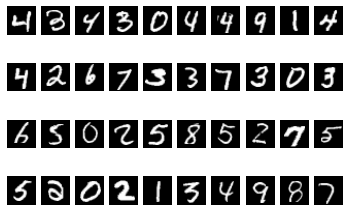

In [92]:
#plot_random_sample(fmnist['data'].values.reshape(-1,28,28))
plot_random_sample(X.reshape(-1,28,28))


In [133]:
len(svc.support_)

2885

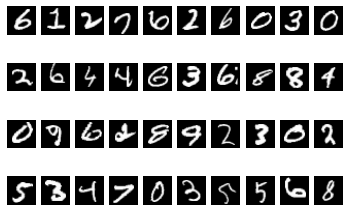

In [134]:
plot_random_sample(svc.support_vectors_.reshape(-1,28,28))

In [135]:
np.unique(y[svc.support_], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([263, 121, 334, 323, 313, 346, 273, 252, 334, 326]))

In [136]:
mnist_images = X.reshape(-1,28,28,1)

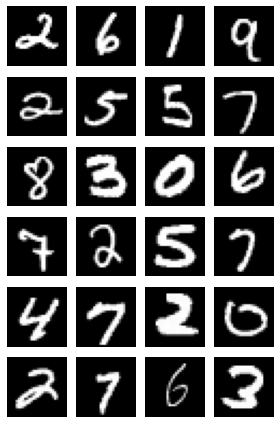

In [137]:
plt.figure(figsize=(4,6), tight_layout=True)
nrow, ncol = 6,4
for i,idx in enumerate(np.random.choice(len(mnist_images), size=nrow*ncol, replace=False)):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(mnist_images[idx], cmap='gray')
        plt.axis('off')
# plt.savefig('plots/12-10-mnist-sample.pdf')

# Mixture data

In [35]:
import urllib
import pandas as pd
import numpy as np
import functools
import subprocess
import os
import json


def load_info(name):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return f.read().decode('utf-8')

def load_csv(name, read_csv_args):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return pd.read_csv(f, **read_csv_args)

def load_label(name):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return np.array([l.strip().decode('utf-8') for l in f.readlines()])
    
def to_array(d):
    if isinstance(d, dict):
        return {k: to_array(v) for k,v in d.items()}
    if isinstance(d, list):
        return np.array(d)
    return d

def load_rda(name):
    cmd = subprocess.run(
               ['Rscript', '--vanilla', 
                '-e' ,
                f'load(url("{ESL_datasets_url}{name}")); jsonlite::write_json(as.list(environment()), stdout())'],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
              )
    if cmd.returncode:
        print(cmd.stderr.decode('utf-8'))
        raise ValueError
    else:
        data = json.loads(cmd.stdout.decode('utf-8'))
        return to_array(data)


ESL_datasets_url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/'

ESL_datasets = {
        'prostate': {
          'meta': functools.partial(load_info, name='prostate.info.txt'), 
          'data': functools.partial(load_csv, name='prostate.data', 
                                    read_csv_args=dict(sep="\t", index_col=0))
        },
        'ozone': {
          'meta': functools.partial(load_info, name='ozone.info.txt'), 
          'data': functools.partial(load_csv, name='ozone.data', 
                                    read_csv_args=dict(sep="\t"))
        },
        'spam': {
          'meta': functools.partial(load_info, name='spam.info.txt'), 
          'data': functools.partial(load_csv, name='spam.data', 
                                    read_csv_args=dict(sep=' ', index_col=None, header=None))
        },
        'phoneme': {
          'meta': functools.partial(load_info, name='phoneme.info.txt'), 
          'data': functools.partial(load_csv, name='phoneme.data', 
                                    read_csv_args=dict(sep=',', index_col=0))
        },
        'nci_microarray': {
          'meta': functools.partial(load_info, name='nci.info.txt'), 
          'data': functools.partial(load_csv, name='nci.data.csv', 
                                    read_csv_args=dict(sep=',', index_col=0)),
          'label': functools.partial(load_label, name='nci.label'),
        },
        'sa_heart_disease': {
          'meta': functools.partial(load_info, name='SAheart.info.txt'), 
          'data': functools.partial(load_csv, name='SAheart.data', 
                                    read_csv_args=dict(sep=',', header=None))
        },    
        'mixture':{
          'meta': functools.partial(load_info, name='mixture.example.info.txt'), 
          'data': functools.partial(load_rda, name='ESL.mixture.rda')
        },
    }   
    
class Dataset:
    def __init__(self, kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)
    def __repr__(self):
        return self.meta + '\n' + repr(self.data)
    def __str__(self):
        return str(self.data)
    
    
def load_ESL_dataset(name):
    return Dataset({k: v() for k, v in ESL_datasets[name].items()})


In [36]:
mixture = load_ESL_dataset('mixture')

In [52]:
X_train = pd.DataFrame(mixture.data['ESL.mixture']['x'], columns=['x1','x2'])
y_train = mixture.data['ESL.mixture']['y']
X_test = mixture.data['ESL.mixture']['xnew']
p_test = mixture.data['ESL.mixture']['prob']
y_test = 1*(p_test>0.5)

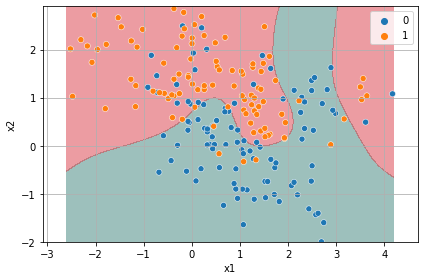

In [111]:
posterior = mixture.data['ESL.mixture']['prob'].reshape(99,-1)
x1 = mixture.data['ESL.mixture']['px1']
x2 = mixture.data['ESL.mixture']['px2']

plt.figure(tight_layout=True)

plt.contourf(x1, x2, posterior, levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = mixture.data['ESL.mixture']['y'], 
                data=X)
plt.grid()

plt.axis('equal')
#plt.savefig('plots/12-10-mixture.pdf')

In [132]:
mixture_poly = GridSearchCV(sksvm.SVC(kernel='poly', coef0=1),
                           param_grid= dict( C=[#0.1, 
                                               1, 
                                                10, 100,], 
                                       degree=[3,4,5], 
                                       coef0=[0.25,0.5,1],
                                           gamma=[0.09, 0.18,0.36,0.72]),
                           cv=5,
                           refit=True
                          ).fit(X,y)
# mixture_svm = .fit(X_train, y_train)
mixture_poly.score(X_train, y_train), mixture_poly.score(X_test, y_test)

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


(0.785, 0.8309178743961353)

In [73]:
mixture.data['ESL.mixture'].keys()


dict_keys(['x', 'y', 'xnew', 'prob', 'marginal', 'px1', 'px2', 'means'])

In [74]:
mixture.data['ESL.mixture']['px2'].shape

(99,)

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


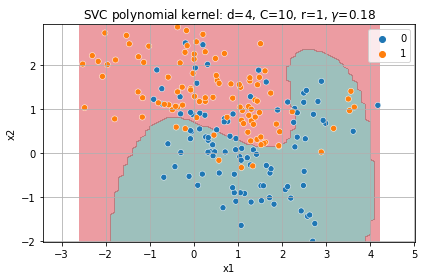

In [133]:
#posterior = mixture.data['ESL.mixture']['prob'].reshape(99,-1)
y_pred_poly = mixture_poly.predict(X_test)
x1 = mixture.data['ESL.mixture']['px1']
x2 = mixture.data['ESL.mixture']['px2']

plt.figure(tight_layout=True)

plt.contourf(x1, x2, (y_pred_poly+0.5).clip(0,1).reshape(x2.shape+x1.shape), levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = y_train, #(y_pred+0.5).clip(0,1), #mixture.data['ESL.mixture']['y'], 
                data=X_train)
plt.grid()

plt.axis('equal')
plt.title('SVC polynomial kernel: d={degree}, C={C}, r={coef0}, $\gamma$={gamma}'.format(**mixture_poly.best_params_))
#plt.savefig('plots/12-10-mixture-poly.pdf')

In [82]:
mixture_svm.best_params_

{'C': 100, 'coef0': 0.5, 'degree': 4}

In [84]:
1/X_train.var(axis=0).sum()

0.36532351023549936

In [104]:
mixture_rbf = GridSearchCV(sksvm.SVC(kernel='rbf', coef0=1),
                           param_grid= dict( C=[0.1, 1, 5, 10, 20, 50, 100], 
                                        gamma =[#0.18,0.36,0.48, 0.72, 
                                            0.9, 1.8, 3.6,7.2]),
                           cv=5,
                           refit=True
                          ).fit(X,y)
# mixture_svm = .fit(X_train, y_train)
mixture_rbf.score(X_train, y_train), mixture_rbf.score(X_test, y_test)

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


(0.85, 0.8241838676621285)

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


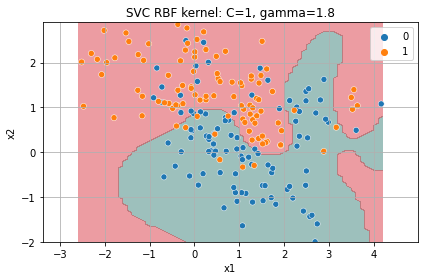

In [134]:
y_pred_rbf = mixture_rbf.predict(X_test)
x1 = mixture.data['ESL.mixture']['px1']
x2 = mixture.data['ESL.mixture']['px2']

plt.figure(tight_layout=True)

plt.contourf(x1, x2, (y_pred_rbf+0.5).clip(0,1).reshape(x2.shape+x1.shape), levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = y_train, #(y_pred+0.5).clip(0,1), #mixture.data['ESL.mixture']['y'], 
                data=X_train)
plt.grid()

plt.axis('equal')
plt.title('SVC RBF kernel: C={C}, gamma={gamma}'.format(**mixture_rbf.best_params_))
#plt.savefig('plots/12-10-mixture-rbf.pdf')

In [87]:
mixture_rbf.best_params_

{'C': 10, 'gamma': 0.72}

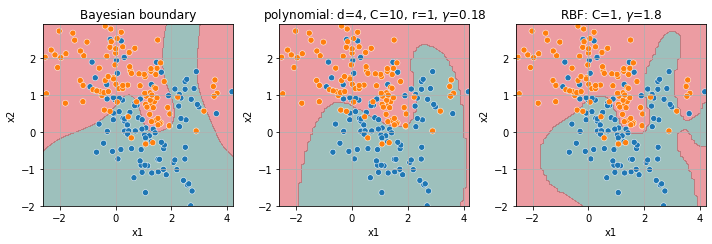

In [135]:
plt.figure(figsize=(10, 3.5),tight_layout=True)

plt.subplot(1,3,1)

plt.contourf(x1, x2, posterior, levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = mixture.data['ESL.mixture']['y'], 
                data=X, legend=False)

plt.grid()
plt.title('Bayesian boundary')

#plt.axis('equal')


plt.subplot(1,3,2)

plt.contourf(x1, x2, (y_pred_poly+0.5).clip(0,1).reshape(x2.shape+x1.shape), levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = y_train, #(y_pred+0.5).clip(0,1), #mixture.data['ESL.mixture']['y'], 
                data=X_train, legend=False)
plt.grid()

#plt.axis('equal')
plt.title('polynomial: d={degree}, C={C}, r={coef0}, $\gamma$={gamma}'.format(**mixture_poly.best_params_))

plt.subplot(1,3,3)

plt.contourf(x1, x2, (y_pred_rbf+0.5).clip(0,1).reshape(x2.shape+x1.shape), levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = y_train, #(y_pred+0.5).clip(0,1), #mixture.data['ESL.mixture']['y'], 
                data=X_train, legend=False)
plt.grid()

#plt.axis('equal')
plt.title('RBF: C={C}, $\gamma$={gamma}'.format(**mixture_rbf.best_params_))


#plt.savefig('plots/12-10-mixture-svm.pdf')

In [136]:
len(mixture_poly.best_estimator_.support_)

117

In [137]:
len(mixture_rbf.best_estimator_.support_)

112

In [128]:
len(X_train)

200